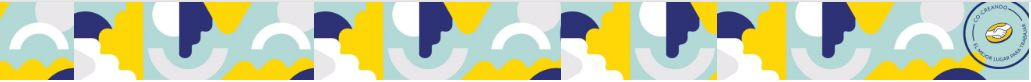

>   
    Fecha               | 12/05/2024
    Realizado por       | Francisco Guzmán
    Objetivo            | Realizar un análisis sobre la oferta/vidriera de las opciones de productos que responden a distintas
                          búsquedas en el sitio Mercadolibre.com.ar  utilizando el lenguaje Python y las bibliotecas
                          que considere necesarias.

En la siguiente notebook se documenta un programa que consume datos de el site https://www.mercadolibre.com.ar/ haciendo uso de la api, para ello el usuario debe ejecutar paso a paso la notebook.

- El primer paso consiste en generar el token. Una vez generado y utilizado el token, usuario tendrá acceso a explotar la información.
- Como segundo paso, el usuario debe escribir por consola el artículo buscado, el programa generará un csv normalizado y lo guardará en una ruta del proyecto para luego ser analizado.
- Una vez obtenidos los resultados de las búsquedas, se cargan los csv de los resultados a comparar y el programa entrega análisis descriptivo de los universos y compara en plot los universos, en donde se puede tener un conocimiento amplio de los productos buscados. Para más detalle te invito a explorar este mágico universo.


**Diagrama general del programa**

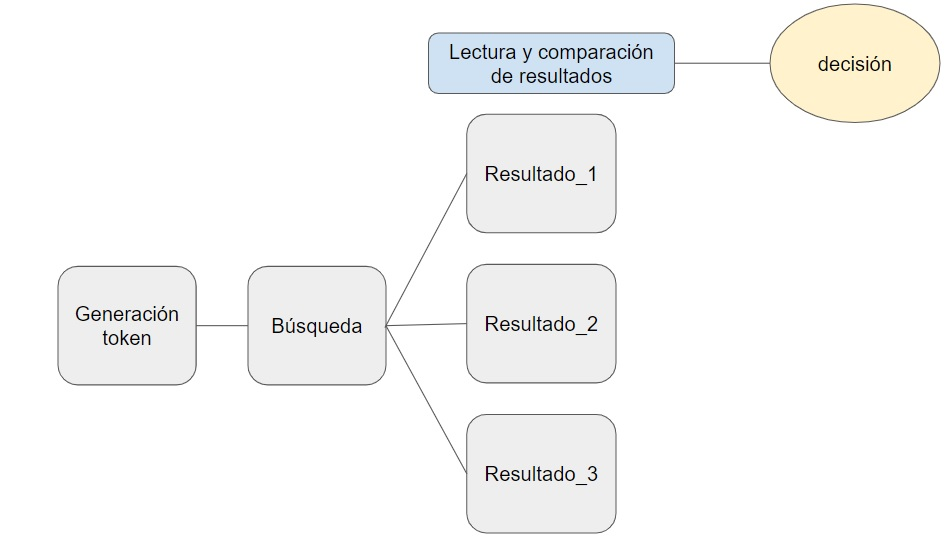




**Datos_app**:

- **App ID** 1729145394197870
- **Client Secret** nWzU5NO1T9DwKkk2eqdbHwy42ifUnYeT
- **Uri** https://garmin.com.ar/
- code= **se genera una vez ingresado en el link**


In [6]:
#librerias
import pandas as pd
import json
import requests
from google.colab import drive
import plotly.express as px

In [7]:
#damos acceso al drive
drive.mount('/content/drive')

Mounted at /content/drive


## Explotación API Meli:

### Generación de token.

Para la generación del token se debe ingresar en el siguiente link y copiar el **TC_CODE**


https://auth.mercadolibre.com.ar/authorization?response_type=code&client_id=1729145394197870&redirect_uri=https://garmin.com.ar/

Ejemplo:

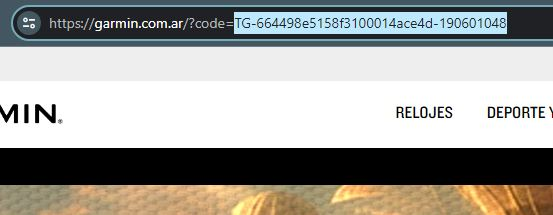

Una vez corrido el codigo a continuación el usuario debera pegar el codigo copiado.

In [8]:
url = "https://api.mercadolibre.com/oauth/token"
tg_code = str(input("Ingrese tg_code, conocido como codigo de verificacion: "))
payload = f'grant_type=authorization_code&client_id=1729145394197870&client_secret=nWzU5NO1T9DwKkk2eqdbHwy42ifUnYeT&code={tg_code}&redirect_uri=https%3A%2F%2Fgarmin.com.ar%2F'
headers = {
  'accept': 'application/json',
  'content-type': 'application/x-www-form-urlencoded'
}

response = requests.request("POST", url, headers=headers, data=payload)

#guardamos access_token en una variable
access_token = response.text.split(':')[1].split(',')[0].strip('"')
print(response.text)

Ingrese tg_code, conocido como codigo de verificacion: TG-664498e5158f3100014ace4d-190601048
{"access_token":"APP_USR-1729145394197870-051507-d9fc62ff56e1de824c2196da308f51c4-190601048","token_type":"Bearer","expires_in":21600,"scope":"offline_access","user_id":190601048,"refresh_token":"TG-664499c3dae88b0001eb411f-190601048"}


### Generación de universo de busqueda.

Al correr el codigo, el usuario debera escribir por consola la busqueda, el programa escribe un csv con el detalle de las 150 publicaciones que encuentra para el elemento buscado y los datos necesarios para evaluar y comparar los resultados a fin de comprar la mejor opción.

In [19]:
#generamos la busqueda y las tres vistas de 50 publicaciones para completar el requerimiento de 150
consola = str(input("Ingrese su búsqueda: "))
csv_file= consola.replace(" ", "_")
buscador = consola.replace(" ", "%20")
url = f'https://api.mercadolibre.com/sites/MLA/search?q={buscador}'
url_2 = f'https://api.mercadolibre.com/sites/MLA/search?q={buscador}&offset=50'
url_3 = f'https://api.mercadolibre.com/sites/MLA/search?q={buscador}&offset=100'
payload = {}
headers = {
  'Authorization': f'Bearer {access_token}'
}
#accedemos a las primeras 150 publicaciones
pagina_1 = requests.request("GET", url, headers=headers, data=payload)
pagina_2 = requests.request("GET", url_2, headers=headers, data=payload)
pagina_3 = requests.request("GET", url_3, headers=headers, data=payload)

paginas = [pagina_1,pagina_2,pagina_3]
#creamos una lista de de dataframes, cada uno contiene el resultado por pagina
mylist = []

#definimos función para sacar texto de los json y normalizar el dato
def carga_y_normalizacion(pagina):
  data = json.loads(pagina.text)
  df = pd.json_normalize(data['results'])
  return mylist.append(df)
#corremos lo antes mencionado para las 3 paginas
for x in paginas:
  carga_y_normalizacion(x)
#apendeamos la información de las paginas
busqueda = pd.concat(mylist, ignore_index=True)
#definimos el GET por Item_Id al recurso público
def consulta_id(id):
      url = f"https://api.mercadolibre.com/items/{id}"
      payload = {}
      headers = {
        'Authorization': f'Bearer {access_token}'
      }
      response = requests.request("GET", url, headers=headers, data=payload)
      json_data = response.text
      data_dict = json.loads(json_data)
      df = pd.DataFrame.from_dict(data_dict, orient='index').transpose()
      return df
#creamos una lista con todas las publicaciones consultadas
mi_lista_final = []
for x in busqueda.id:
  mi_lista_final.append(consulta_id(x))
#finalmente creamos el dataframe con los valores del analisis
articulo = pd.concat(mi_lista_final, ignore_index=True)
articulo["free_shipping_ind"] = [x["free_shipping"] for x in articulo.shipping]
articulo = articulo[['price', 'title', 'buying_mode','condition','accepts_mercadopago', 'warranty', 'free_shipping_ind', 'date_created', 'last_updated']]
articulo['etiqueta_busqueda'] = [csv_file for x in articulo.date_created]
articulo.to_csv(f'/content/drive/MyDrive/challenge/outpus/{csv_file}.csv',index =False)

Ingrese su búsqueda: Motorola 40


## Universos de busquedas para comparar.
Para el siguiente ejercicio buscamos 3 modelos de telefonos y comparamos la información obtenida para ver cual nos conviene comprar.

Busquedas practicas.
- Iphone 14
- Samsung s23
- Motorola 40

In [20]:
#Leemos los archivos escritos en csv
Iphone_14 = pd.read_csv('/content/drive/MyDrive/challenge/outpus/Iphone_14.csv')
Samsung_s23 = pd.read_csv('/content/drive/MyDrive/challenge/outpus/Samsung_s23.csv')
Motorola_40 = pd.read_csv('/content/drive/MyDrive/challenge/outpus/Motorola_40.csv')

In [45]:
#creamos un solo universo para comparar
busquedas = [Iphone_14,Samsung_s23,Motorola_40]
for x in busquedas:
  df_busquedas = pd.concat(busquedas)

La información que mostramos **a continuación** nos ayuda en la evaluación del Precio y el Modo de Compra antes de tomar cualquier decisión, tambien nos ayuda a verificar el modo de compra. Por ejemplo, el producto puede estar disponible para comprar en "compra inmediata".

**MercadoPago**
Otro aspecto crucial es si el vendedor acepta MercadoPago lo que me da la confianza de que mi transacción será segura y rápida.

**Garantía y Envío**
Reviso si el producto tiene garantía, lo que me da tranquilidad en caso de que surja algún problema.

Además, me fijo en la indicación de envío gratuito. Veo que el producto incluye envío gratuito, lo cual es un gran incentivo, ya que me ahorra costos adicionales.

**Conclusión**
Después de revisar todas estas variables, decido proceder con la compra. Hago clic en "Comprar ahora", elijo MercadoPago como mi método de pago, y aprovecho el envío gratuito. Me siento seguro sabiendo que tengo una garantía de 1 año para estos aproductos.

### Estadisticas descriptivas por búsqueda:

Nos ayuda a entender las características del artículo buscado.

In [49]:
print('Busqueda: Iphone_14')
Iphone_14.describe(include=['O'])

Busqueda: Iphone_14


,title,buying_mode,condition,warranty,date_created,last_updated,etiqueta_busqueda
count,150,150,150,145,150,150,150
unique,135,1,2,23,150,150,1
top,iPhone 14 Pro Max,buy_it_now,new,Sin garantía,2024-02-27T18:52:59.000Z,2024-05-14T21:51:29.000Z,Iphone_14
freq,5,150,76,59,1,1,150


In [50]:
print('Busqueda: Samsung_s23')
Samsung_s23.describe(include=['O'])

Busqueda: Samsung_s23


,title,buying_mode,condition,warranty,date_created,last_updated,etiqueta_busqueda
count,150,150,150,146,150,150,150
unique,129,1,2,21,142,150,1
top,Samsung Galaxy S23 Ultra 512gb Color Verde Mas...,buy_it_now,new,Sin garantía,2024-05-15T03:43:14.000Z,2024-05-15T10:57:08.378Z,Samsung_s23
freq,4,150,80,46,7,1,150


In [51]:
print('Busqueda: Motorola_40')
Motorola_40.describe(include=['O'])

Busqueda: Motorola_40


,title,buying_mode,condition,warranty,date_created,last_updated,etiqueta_busqueda
count,150,150,150,145,150,150,150
unique,130,1,2,21,150,150,1
top,Celular Motorola E40,buy_it_now,used,Sin garantía,2024-01-05T13:33:18.000Z,2024-05-15T11:10:36.568Z,Motorola_40
freq,4,150,78,48,1,1,150


#Comparación de busquedas:

In [39]:
fig = px.box(df_busquedas, x="etiqueta_busqueda", y="price", color="etiqueta_busqueda", notched=True)
fig.show()